# Аналитика в Яндекс.Афише

### Описание проекта

Необходимо помочь маркетологам оптимизировать маркетинговые затраты.
В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

### Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

#### Шаг 1. Загрузите данные и подготовьте их к анализу

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

### Посещения

In [2]:
#Считаем датасет visits
df_visits = pd.read_csv('/datasets/visits_log.csv')
# Посмотрим данные
df_visits

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [3]:
# Посмотрим наличие пропусков и типы данных
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
# Переведем даты начала и окончания сессии в datetime
df_visits['End Ts'] = pd.to_datetime(df_visits['End Ts'])
df_visits['Start Ts'] = pd.to_datetime(df_visits['Start Ts'])

### Заказы

In [5]:
#Считаем датасет orders
df_orders = pd.read_csv('/datasets/orders_log.csv')
# Посмотрим данные
df_orders

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [6]:
# Посмотрим наличие пропусков и типы данных
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
# Переведем дату и время заказа в datetime
df_orders['Buy Ts'] = pd.to_datetime(df_orders['Buy Ts'])

### Затраты

In [8]:
#Считаем датасет costs
df_costs = pd.read_csv('/datasets/costs.csv')
# Посмотрим данные
df_costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [9]:
# Посмотрим наличие пропусков и типы данных
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [10]:
# Переведем дату в datetime
df_costs['dt'] = pd.to_datetime(df_costs['dt'])

##### Имеется 3 таблицы: посещения, заказы и затраты. Пропуски в данных отсутствуют. Все даты были переведены в формат datetime.

### Шаг 2. Отчёты и метрики

### Продукт
- 1) Сколько людей пользуются в день, неделю, месяц?
- 2) Сколько сессий в день?
- 3) Сколько длится одна сессия?
- 4) Как часто люди возвращаются?

In [11]:
# Добавим столбцы с днем недели, месяцем и годом
df_visits['session_year'] = df_visits['Start Ts'].astype('datetime64[Y]')
df_visits['session_month'] = df_visits['Start Ts'].astype('datetime64[M]')
df_visits['session_week'] = df_visits['Start Ts'].astype('datetime64[W]')
df_visits['session_date'] = df_visits['Start Ts'].dt.date

#### 1) Сколько людей пользуются в день, неделю, месяц?

In [12]:
# Сгруппируем данные по дню, непделе и месяцу, и посмортим число уникальных пользрователей
dau_total = df_visits.groupby('session_date').agg({'Uid': 'nunique'}).mean()
wau_total = df_visits.groupby('session_week').agg({'Uid': 'nunique'}).mean()
mau_total = df_visits.groupby('session_month').agg({'Uid': 'nunique'}).mean()

print('DAU за весь период:', int(dau_total), 'пользователей')
print('WAU за весь период:', int(wau_total), 'пользователей')
print('MAU за весь период:', int(mau_total), 'пользователей')

DAU за весь период: 907 пользователей
WAU за весь период: 5724 пользователей
MAU за весь период: 23228 пользователей


##### В среднем сайт посещают 907 человек в день, 5724 в неделю и 23228 в месяц.

#### 2) Сколько сессий в день?

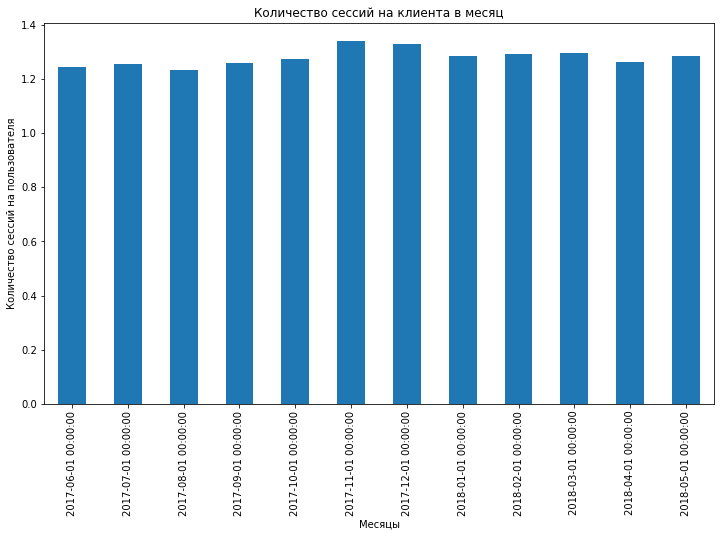

In [13]:
# Рассчитаем число сессий на каждого клиента
sess_per_user = df_visits.groupby('session_month').agg({'Uid': ['count', 'nunique']})
sess_per_user.columns = ['n_sessions', 'n_users']
sess_per_user['sess_per_user'] = sess_per_user['n_sessions'] / sess_per_user['n_users']
sess_per_user['sess_per_user'].plot(kind = 'bar', figsize=(12,7)).set_title('Количество сессий на клиента в месяц')
plt.ylabel("Количество сессий на пользователя")
plt.xlabel("Месяцы")
plt.show()

##### В среднем на одного пользователя приходится примерно 1.3 сессии в месяц. Большинство пользователей посещают сайт не чаще одного раза в месяц.

#### 3) Сколько длится одна сессия?

In [14]:
#Введем столбец со временем, проведенным пользователем на сайте
df_visits['session_duration_sec'] = (df_visits['End Ts'] - df_visits['Start Ts']).dt.seconds

In [15]:
#Посмотрим на распределение врем ени на сайте
df_visits['session_duration_sec'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

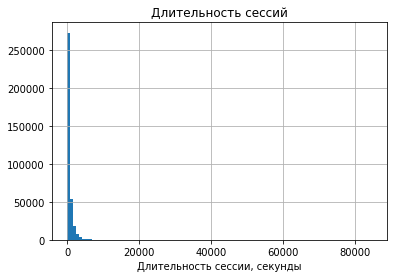

In [16]:
df_visits['session_duration_sec'].hist(bins = 100).set_title('Длительность сессий')
plt.xlabel("Длительность сессии, секунды")
plt.show()

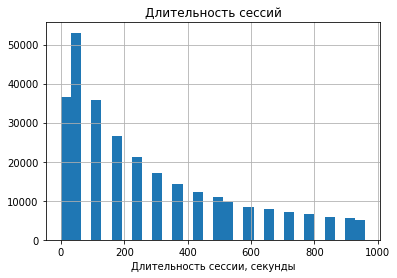

In [17]:
# Рассмотрим частоту сессий, длительнгостью меньше 1000 секунд
df_visits.query('session_duration_sec < 1000')['session_duration_sec'].hist(bins = 30).set_title('Длительность сессий')
plt.xlabel("Длительность сессии, секунды")
plt.show()

In [18]:
# Рассмотрим медиану, моду и среднее значение длительноти сессии
print('Средняя длительность сессии: {:.2f} сек'.format(df_visits['session_duration_sec'].mean()))
print('Медианная длительность сессии: {:.2f} сек'.format(df_visits['session_duration_sec'].median()))
print('Мода длительность сессии: {:.2f} сек'.format(df_visits['session_duration_sec'].mode()[0]))

Средняя длительность сессии: 643.51 сек
Медианная длительность сессии: 300.00 сек
Мода длительность сессии: 60.00 сек


##### В среднем пользователи проводят на сайте чуть больше 10 минут, при этом медианное значение - 5 минут. У распредеоения времени на сайте имеется огромный хвост, но 75% пользователей проводят на сайте до 14 минут. 25% пользователей проводят на сайте до 2 минут. Это может быть связано со случайным кликом на ссылку в поисковике, либо пользователи не разобрались в интерфейсе при заходе на сайт и сразу вышли.

##### 4) Как часто люди возвращаются?

In [19]:
# Возьмём дату, когда пользователь впервые проявил активность на сайте
first_visits = df_visits.groupby(['Uid'])['Start Ts'].min().reset_index()
first_visits.name = 'first_session_start'
# first_visits.colums = ['Uid', 'first_session_start_ts']
first_visits.head()

,Uid,Start Ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [20]:
# Изменим тип столбцов
first_visits['first_session_year'] = first_visits['Start Ts'].astype('datetime64[Y]')
first_visits['first_session_month'] = first_visits['Start Ts'].astype('datetime64[M]')
first_visits['first_session_week'] = first_visits['Start Ts'].astype('datetime64[W]')
first_visits['first_session_dt'] = first_visits['Start Ts'].dt.date

In [21]:
#Объединим таблицы с посещениями и первыми посещениями
vis = pd.merge(first_visits, df_visits, on = 'Uid')
#Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты
vis['age_days'] = vis['session_date'] - vis['first_session_dt']
vis['age_months'] = (((vis['session_month'] - vis['first_session_month'])) / np.timedelta64(1,'M')).round().astype('int')

In [22]:
#Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:
cohorts = vis.pivot_table(index = 'first_session_month',
                         columns = 'age_months',
                         values = 'Uid',
                         aggfunc = 'nunique')
cohorts.fillna('')

age_months,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,13259.0,1043,713,814,909,947,809,766,694,674,539,596
2017-07-01,13140.0,737,674,738,765,633,596,601,510,376,361,
2017-08-01,10181.0,783,640,639,510,448,370,402,284,265,,
2017-09-01,16704.0,1428,1156,847,658,632,599,404,381,,,
2017-10-01,25977.0,2042,1357,1012,890,837,555,529,,,,
2017-11-01,27248.0,2133,1202,1054,919,638,594,,,,,
2017-12-01,25268.0,1410,960,786,512,481,,,,,,
2018-01-01,22624.0,1351,890,565,458,,,,,,,
2018-02-01,22197.0,1267,565,446,,,,,,,,


In [23]:
# Рассчитаем Retention rate
retention = pd.DataFrame()
for col in cohorts.columns:
    retention = pd.concat([retention, cohorts[col]/cohorts[0]], axis = 1)
retention.columns = cohorts.columns
retention.fillna('')

age_months,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01 00:00:00,1.0,0.0786635,0.0537748,0.0613923,0.0685572,0.0714232,0.0610152,0.0577721,0.0523418,0.0508334,0.0406516,0.0449506
2017-07-01 00:00:00,1.0,0.0560883,0.0512938,0.0561644,0.0582192,0.0481735,0.0453577,0.0457382,0.0388128,0.0286149,0.0274734,
2017-08-01 00:00:00,1.0,0.076908,0.0628622,0.062764,0.0500933,0.0440035,0.0363422,0.0394853,0.0278951,0.0260289,,
2017-09-01 00:00:00,1.0,0.0854885,0.069205,0.0507064,0.0393918,0.0378352,0.0358597,0.0241858,0.0228089,,,
2017-10-01 00:00:00,1.0,0.078608,0.0522385,0.0389575,0.0342611,0.0322208,0.0213651,0.0203642,,,,
2017-11-01 00:00:00,1.0,0.078281,0.0441133,0.0386817,0.0337272,0.0234146,0.0217998,,,,,
2017-12-01 00:00:00,1.0,0.0558018,0.0379927,0.0311065,0.0202628,0.0190359,,,,,,
2018-01-01 00:00:00,1.0,0.0597153,0.0393388,0.0249735,0.020244,,,,,,,
2018-02-01 00:00:00,1.0,0.0570798,0.0254539,0.0200928,,,,,,,,
2018-03-01 00:00:00,1.0,0.0418184,0.0270533,,,,,,,,,


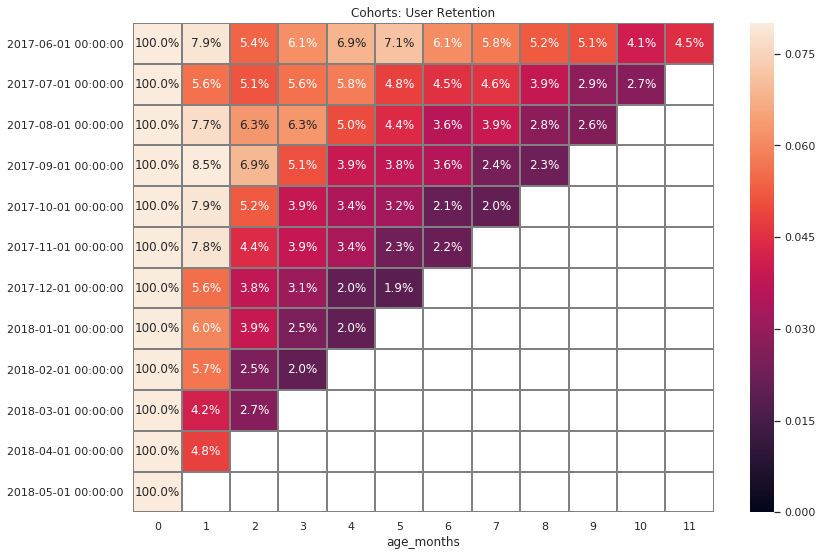

In [24]:
#Построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.08);

In [25]:
print('В среднем {0:.0%} пользователей возвращается на следующий месяц после первого использования'.format(retention[1].mean()))

В среднем 7% пользователей возвращается на следующий месяц после первого использования


##### В среднем 7% пользователей возвращается на следующий месяц после первого использования сайта. По тепловой карте видно, что на второй месяц возвращается 2-6% пользователей. Далее число пользователей медленно падает, хотя в некоторых когортах на 3-ий - 4-ый месяц количесвто возврашающихся пользователей повышается. Кроме того, видно, что за последние месяцы retention rate меньше, чем в ранние месяцы. То есть последнее время новые пользователи все реже возвращаются на сайт.

### Продажи
- 1) Когда люди начинают покупать?
- 2) Сколько раз покупают за период?
- 3) Какой средний чек?
- 4) Сколько денег приносят? (LTV)

##### 1) Когда люди начинают покупать?

In [26]:
# Переведем даты в datetime
df_orders['buy_year'] = df_orders['Buy Ts'].astype('datetime64[Y]')
df_orders['buy_month'] = df_orders['Buy Ts'].astype('datetime64[M]')
df_orders['buy_week'] = df_orders['Buy Ts'].astype('datetime64[W]')
df_orders['buy_dt'] = df_orders['Buy Ts'].dt.date

In [27]:
# Посмроим таблицу, в которой будут даты первых заказов на сайте
first_orders = df_orders.groupby(['Uid'])['Buy Ts'].min().reset_index()

In [28]:
# Объединим таблицы с первыми посещениями сайта и первыми заказами
sales = pd.merge(first_visits, first_orders, on = 'Uid')

In [29]:
#Рассчитаем время между посещением сайта и покупкой
sales['when_buy'] = (sales['Buy Ts'] - sales['Start Ts']).dt.seconds/60

In [30]:
#Рассмотрим распределение
sales['when_buy'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: when_buy, dtype: float64

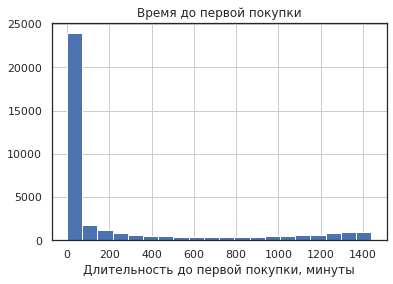

In [31]:
sales['when_buy'].hist(bins = 20).set_title('Время до первой покупки')
plt.xlabel("Длительность до первой покупки, минуты")
plt.show()

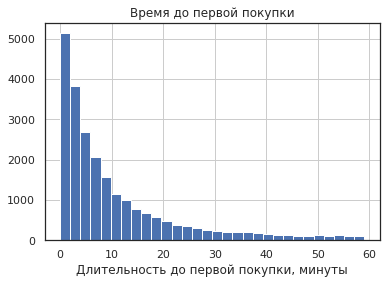

In [32]:
# Рассмотрим распределение до 60 минут
sales.query('when_buy < 60')['when_buy'].hist(bins = 30).set_title('Время до первой покупки')
plt.xlabel("Длительность до первой покупки, минуты")
plt.show()

In [33]:
print('Меддианное время до первой покупки равно {0:} минутам'.format(round(sales['when_buy'].median(),1)))

Меддианное время до первой покупки равно 16.0 минутам


##### Меддианное время до первой покупки равно 16.0 минутам. 75% пользователей совершают покупку в течение 4 часов. У распределения имеется больщой хвост.

##### 2) Сколько раз покупают за период?

In [34]:
orders_per_month = df_orders.groupby('buy_month').agg({'Uid': 'nunique'}).reset_index()
print('В среднем за месяц люди покупают {0:} раз'.format(round(orders_per_month['Uid'].mean(),1)))

В среднем за месяц люди покупают 3155.3 раз


In [35]:
# Рассчитаем, как меняется число покупок по когортам
sales['first_buy_month'] = sales['Buy Ts'].astype('datetime64[M]')
sales['cohort_lifetime']= ((sales['first_buy_month'] - sales['first_session_month'])/np.timedelta64(1,'M')).round().astype(int)

In [36]:
cohorts = sales.groupby(['first_session_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()

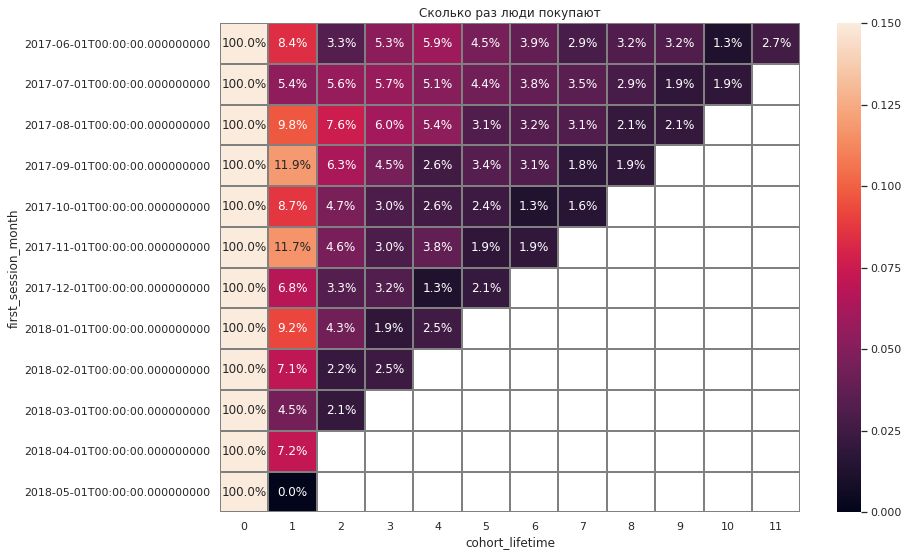

In [37]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_session_month')
cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(index='first_session_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention.fillna('')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Сколько раз люди покупают')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.15)

##### В среднем за месяц люди покупают 3155 раз. Повторные покупки со временем совершаются реже на 2-9%. 

##### 3) Какой средний чек?

In [38]:
print('Средний чек равен {0:}'.format(round(df_orders['Revenue'].mean(),1)))

Средний чек равен 5.0


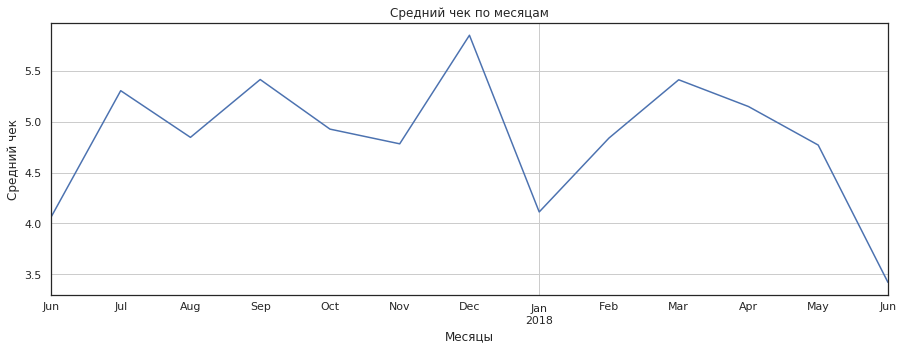

In [39]:
# Посмотрим, как меняется средний чек по месяцам
df_orders.groupby('buy_month')['Revenue'].mean().plot(figsize=(15,5), grid = True).set_title('Средний чек по месяцам')
plt.ylabel("Средний чек")
plt.xlabel("Месяцы")
plt.show()

##### Срдний чек равен 5.0. В течение года он менялся от 3.3 до 5.8. Последни 2 месяца наблюдается падение среднего чека. 

##### 4) Сколько денег приносят? (LTV)

In [40]:
df_costs['month'] = df_costs['dt'].astype('datetime64[M]')

In [41]:
# Найдем дату первой покупки каждого покупателя
first_orders = df_orders.groupby('Uid').agg({'buy_month': 'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order_month']

In [42]:
# Вычислим число новых покупателей за каждую дату
cohort_sizes = first_orders.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
print(cohort_sizes.head())

  first_order_month  n_buyers
0        2017-06-01      2023
1        2017-07-01      1923
2        2017-08-01      1370
3        2017-09-01      2581
4        2017-10-01      4340


In [43]:
# Добавим дату первой покупки в таблицу с заказами
orders_new = pd.merge(df_orders,first_orders, on='Uid')
orders_new.head()

,Buy Ts,Revenue,Uid,buy_year,buy_month,buy_week,buy_dt,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-01-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-01-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-01-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-01-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-01-01,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [44]:
# Сгруппируем таблицу и посчитаем выручку
cohorts = orders_new.groupby(['first_order_month','buy_month']).agg({'Revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,buy_month,Revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [45]:
# Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,buy_month,Revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [46]:
# Маржинальность примем равной 1
margin_rate = 1
# Рассчитаем валовую прибыль    
report['gp'] = report['Revenue'] * margin_rate
report['age'] = (report['buy_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,buy_month,Revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


In [47]:
# Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round()
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,5.0,0,0,1,1,1,1,1,1,1,1,0
2017-07-01,6.0,0,1,0,0,0,0,0,0,0,0,
2017-08-01,5.0,0,0,0,0,0,0,0,0,0,,
2017-09-01,6.0,1,1,4,0,1,1,0,0,,,
2017-10-01,5.0,1,0,0,0,0,0,0,,,,
2017-11-01,5.0,0,0,0,0,0,0,,,,,
2017-12-01,5.0,0,1,1,0,0,,,,,,
2018-01-01,4.0,0,0,0,0,,,,,,,
2018-02-01,4.0,0,0,0,,,,,,,,


In [48]:
monthly_costs = df_costs.groupby('month').sum()
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean')

final_result = report_new.pivot_table( index='first_order_month', columns='age', values='ltv', aggfunc='mean')

m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5]

print('Средний LTV за 6 месяцев после первой покупки:', round(m6_cum_ltv, 2))

Средний LTV за 6 месяцев после первой покупки: 7.97


In [49]:
final_result.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Все когорты окупают себя в первый же месяц, и со временем LTV растет. 

### Маркетинг
- 1) Сколько денег потратили? Всего / на каждый источник / по времени
- 2) Сколько стоило привлечение одного покупателя из каждого источника?
- 3) На сколько окупились расходы? (ROI)

##### 1) Сколько денег потратили? Всего / на каждый источник / по времени

In [50]:
print('Всего на рекламу было потрачено:', round(df_costs['costs'].sum(), 1))

Всего на рекламу было потрачено: 329131.6


In [51]:
# Сгруппируем данные затрат по источникам
df_costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

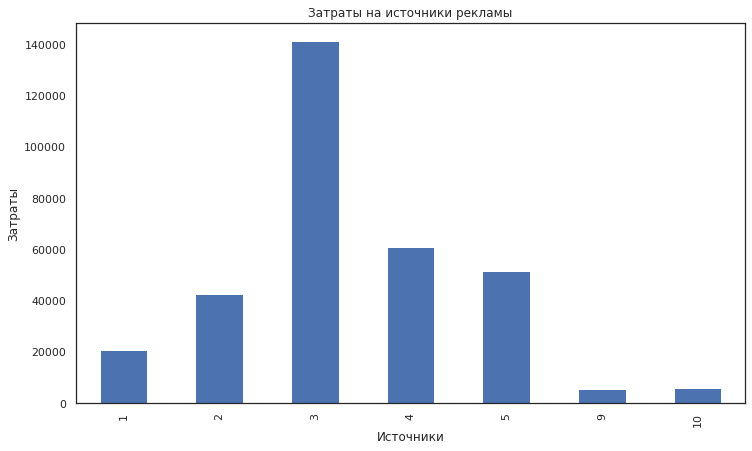

In [52]:
#Посмотрим, сколько денег уходит на каждый источник рекламы
df_costs.groupby('source_id')['costs'].sum().plot(kind = 'bar', figsize=(12,7)).set_title('Затраты на источники рекламы')
plt.ylabel("Затраты")
plt.xlabel("Источники")
plt.show()

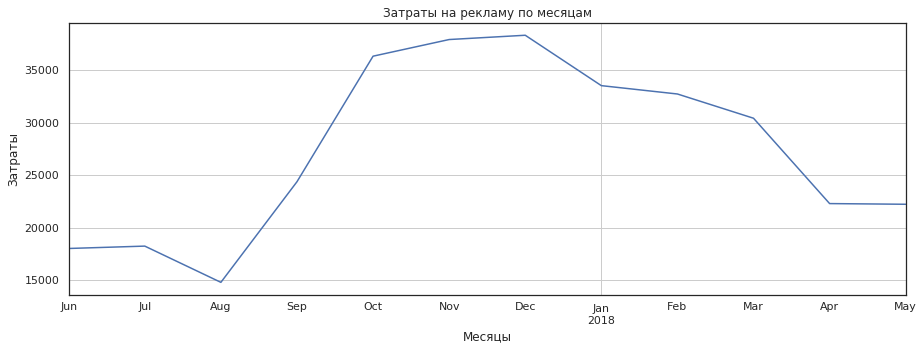

In [53]:
#Посмотрим на затраты на рекламу по месяцам
df_costs.groupby('month')['costs'].sum().plot(figsize=(15,5), grid = True).set_title('Затраты на рекламу по месяцам')
plt.ylabel("Затраты")
plt.xlabel("Месяцы")
plt.show()

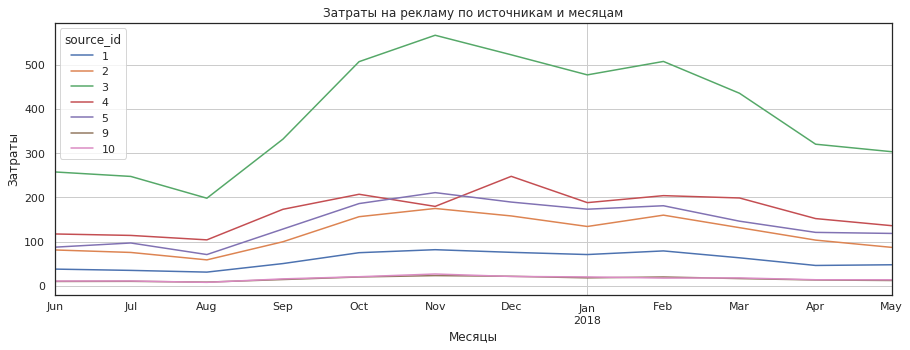

In [54]:
df_costs.pivot_table(index= 'month',columns = 'source_id', values='costs').plot(figsize=(15,5), grid = True).set_title('Затраты на рекламу по источникам и месяцам')
plt.ylabel("Затраты")
plt.xlabel("Месяцы")
plt.show()

##### Всего на рекламу было потрачено: 329131.6
##### Больше всег затрат было на источник № 3, далее идут источники 4 и 5. Меньше всего затрат было на источники № 9 и 10. 
##### После августа резко увеличились затраты на рекламу, пик был достигнут в декабре. Далее затраты падали. Видно, что основной рост затрат произошел именно засчет источника №3, который по форме повторяет форму графика общих затрат.

##### 2) Сколько стоило привлечение одного покупателя из каждого источника?

In [55]:
# сгруппировать табличку costs по месяцу и источнику трафику, вычислить сумму затрат
costs_pivot = df_costs.pivot_table(
        index= ['month', 'source_id'], 
        values='costs', 
        aggfunc='sum').reset_index()

In [56]:
# Для каждого пользователя посмотрим, засчет какого источника он сделал покупку на сайте
first_orders = df_orders.groupby(['Uid']).agg({'buy_month': 'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order_month']

first_visits = df_visits.groupby(['Uid']).agg({'session_month': 'min','Source Id': 'first' }).reset_index()
first_visits.columns = ['Uid', 'first_visit_month', 'source_id']

sales = pd.merge(first_visits, first_orders, on = 'Uid')

cohort_sizes = sales.pivot_table(
        index= ['first_order_month', 'source_id'], 
        values='Uid', 
        aggfunc= {'Uid' : pd.Series.nunique}).reset_index()


cohort_sizes.columns = ['month', 'source_id', 'n_buyers']
display(cohort_sizes.head())

,month,source_id,n_buyers
0,2017-06-01,1,203
1,2017-06-01,2,271
2,2017-06-01,3,574
3,2017-06-01,4,417
4,2017-06-01,5,368


In [57]:
# Объединим таблицы посещений сайта и затрат на источники рекламы
new_buyers = pd.merge(cohort_sizes, costs_pivot, on = ['month', 'source_id'])

In [58]:
# Посчитаем стоимость привлечения покупателя
new_buyers['cac'] = new_buyers['costs'] / new_buyers['n_buyers'] 

In [59]:
print('В среднем стоимость привлечения одного покупателя равна:', round(new_buyers['cac'].mean(), 1))

В среднем стоимость привлечения одного покупателя равна: 7.9


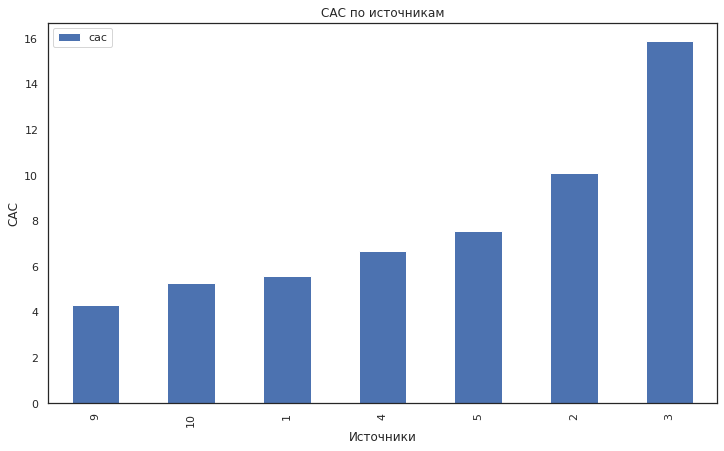

In [60]:
# Посмотрим на среднюю стоимость привлечения покупателя по источникам
new_buyers.pivot_table(
        index= 'source_id', 
        values='cac', 
        aggfunc= 'mean').sort_values(by='cac').plot(kind = 'bar', figsize=(12,7)).set_title('САС по источникам')
plt.ylabel("САС")
plt.xlabel("Источники")
plt.show()

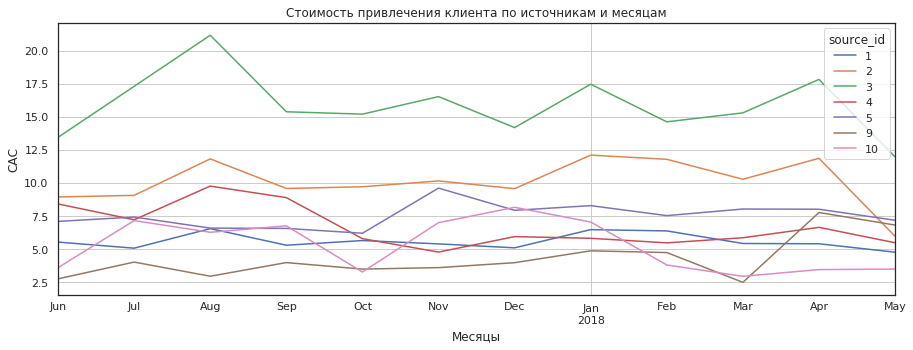

In [61]:
# Посмотрим на стоимость привлечения клиента по месяцам и источникам
new_buyers.pivot_table(index= 'month',columns = 'source_id', values='cac').plot(figsize=(15,5), grid = True).set_title('Стоимость привлечения клиента по источникам и месяцам')
plt.ylabel("САС")
plt.xlabel("Месяцы")
plt.show()

##### В среднем стоимость привлечения одного покупателя равна 7.9
##### В среднем, самые дешевые источники по привлечению клиентов  № 9, 10 и 1. А самые высоки САС у источников № 3, 2 и 5.
##### В течение года стоимость привлечения клиента менялась от 2.5 до 21.5 из разных источнков. Видно, что в разные месяцы САС разных источников менялся независимо от других.

##### 3) На сколько окупились расходы? (ROI)

In [62]:
# сгруппируем табличку costs по месяцу и источнику трафику, вычислим сумму затрат
costs_pivot = df_costs.pivot_table(
        index= ['month', 'source_id'], 
        values='costs', 
        aggfunc='sum').reset_index()

In [63]:
# Сгруппируем таблицу, в которой будут отражены даты первого захода на сайт и первой покупки у каждого клиента
first_orders = df_orders.groupby(['Uid']).agg({'buy_month': 'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order_month']

first_visits = df_visits.groupby(['Uid']).agg({'session_month': 'min','Source Id': 'first' }).reset_index()
first_visits.columns = ['Uid', 'first_visit_month', 'source_id']

sales = pd.merge(first_visits, first_orders, on = 'Uid')

In [64]:
# Сгруппируем таблицу по числу уникальных пользователей по первому месяцу покупки и источнику рекламы
cohort_sizes = sales.pivot_table(
        index= ['first_order_month', 'source_id'], 
        values=['Uid'], 
        aggfunc= {'Uid' : lambda x: len(x.unique())}).reset_index()
cohort_sizes.columns = ['first_order_month', 'source_id', 'n_buyers']
display(cohort_sizes.head())

,first_order_month,source_id,n_buyers
0,2017-06-01,1,203
1,2017-06-01,2,271
2,2017-06-01,3,574
3,2017-06-01,4,417
4,2017-06-01,5,368


In [65]:
# Объединим таблицы заказов и визитов
orders_new = pd.merge(df_orders,first_orders, on='Uid')
orders = pd.merge(first_visits, orders_new, on = 'Uid')

In [66]:
# Подсчитаем прибыль по источникам рекламы
cohorts = orders.groupby(['first_order_month','buy_month', 'source_id']).agg({'Revenue': 'sum'}).reset_index()
display(cohorts.head())

,first_order_month,buy_month,source_id,Revenue
0,2017-06-01,2017-06-01,1,1168.45
1,2017-06-01,2017-06-01,2,1551.76
2,2017-06-01,2017-06-01,3,2466.71
3,2017-06-01,2017-06-01,4,2039.64
4,2017-06-01,2017-06-01,5,1787.68


In [67]:
# Создадим таблицу отчета
report = pd.merge(cohort_sizes, cohorts, on= ['first_order_month', 'source_id'])

In [68]:
# Маржинальность примем равной 1 и подсчитаем валовую прибыль
margin_rate = 1
    
report['gp'] = report['Revenue'] * margin_rate
report['age'] = (report['buy_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [69]:
# Рассчитаем LTV
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns=['age', 'source_id'], 
        values='ltv', 
        aggfunc='mean').round()
    
output.fillna('')

age               0                         1      ... 10          11        \
source_id         1  2  3    4  5  7  9  10 1  2   ... 3  4  5  9  1  2  3    
first_order_month                                  ...                        
2017-06-01         6  6  4  5.0  5     3  2  2  1  ...  0  1  0  0  1  1  0   
2017-07-01         8  7  5  6.0  5     6  3  1  1  ...  0  0  0  0            
2017-08-01         6  6  6  5.0  5  1  5  5  0  1  ...                        
2017-09-01         8  9  5  5.0  5     4  2  1  7  ...                        
2017-10-01         6  7  4  4.0  5     4  3  1  2  ...                        
2017-11-01         6  6  5  5.0  5     4  4  0  1  ...                        
2017-12-01         4  7  4  4.0  5     4  4  0  1  ...                        
2018-01-01         6  4  4  4.0  4     3  3  1  0  ...                        
2018-02-01         5  5  4  4.0  4     4  3  1  0  ...                        
2018-03-01         8  6  4  4.0  5     3  3  2  0  ...                        
2018-04-01         6  6  4  5.0  4     5  2  2  1  ...                        
2018-05-01         5  6  4  5.0  4     4  4        ...                        
2018-06-01                  3.0                    ...                        

age                         
source_id         4  5  10  
first_order_month           
2017-06-01         0  0  0  
2017-07-01                  
2017-08-01                  
2017-09-01                  
2017-10-01                  
2017-11-01                  
2017-12-01                  
2018-01-01                  
2018-02-01                  
2018-03-01                  
2018-04-01                  
2018-05-01                  
2018-06-01                  

[13 rows x 82 columns]

In [70]:
# Рассчитаем САС
costs_pivot.columns = ['first_order_month', 'source_id', 'costs']
report_new = pd.merge(report, costs_pivot, on = ['first_order_month', 'source_id'])
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,source_id,n_buyers,buy_month,Revenue,gp,age,ltv,costs,cac
0,2017-06-01,1,203,2017-06-01,1168.45,1168.45,0,5.755911,1125.61,5.544877
1,2017-06-01,1,203,2017-07-01,362.94,362.94,1,1.787882,1125.61,5.544877
2,2017-06-01,1,203,2017-08-01,153.72,153.72,2,0.757241,1125.61,5.544877
3,2017-06-01,1,203,2017-09-01,695.88,695.88,3,3.427980,1125.61,5.544877
4,2017-06-01,1,203,2017-10-01,760.74,760.74,4,3.747488,1125.61,5.544877


In [71]:
# Рассчитаем ROMI
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index= ['first_order_month','source_id'], 
        columns= 'age', 
        values='romi', 
        aggfunc='mean').reset_index()


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.04,1.36,1.50,2.12,2.79,3.43,4.29,4.64,5.04,5.60,6.14,6.24
2017-07-01,1.51,1.71,2.49,2.71,2.79,2.93,3.01,3.10,3.18,3.26,3.40,NaN
2017-08-01,0.93,0.99,1.01,1.08,1.12,1.14,1.21,1.28,1.30,1.34,NaN,NaN
2017-09-01,1.43,1.60,1.86,2.11,2.22,2.27,2.73,2.88,2.98,NaN,NaN,NaN
2017-10-01,1.07,1.27,1.37,1.43,1.46,1.47,1.51,1.55,NaN,NaN,NaN,NaN
2017-11-01,1.07,1.16,1.28,1.35,1.38,1.38,1.40,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.87,0.91,0.97,1.01,1.04,1.07,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.94,1.13,1.18,1.30,1.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.78,0.98,1.00,1.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.64,0.75,0.86,1.17,1.48,1.67,1.92,2.14,2.27,2.39,2.47,2.59
2017-07-01,0.78,0.86,0.89,0.97,1.01,1.02,1.05,1.06,1.09,1.11,1.16,NaN
2017-08-01,0.48,0.56,0.61,0.61,0.64,0.66,0.66,0.68,0.71,0.72,NaN,NaN
2017-09-01,0.91,1.64,1.90,5.14,5.40,5.85,6.15,6.26,6.34,NaN,NaN,NaN
2017-10-01,0.77,1.01,1.05,1.09,1.12,1.17,1.18,1.20,NaN,NaN,NaN,NaN
2017-11-01,0.62,0.71,0.75,0.82,0.84,0.86,0.87,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.77,0.91,1.64,2.52,2.75,3.01,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.36,0.38,0.45,0.46,0.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.38,0.41,0.42,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.32,0.33,0.33,0.35,0.37,0.37,0.38,0.38,0.38,0.39,0.39,0.39
2017-07-01,0.30,0.31,0.31,0.32,0.32,0.32,0.32,0.33,0.33,0.33,0.34,NaN
2017-08-01,0.26,0.27,0.27,0.28,0.29,0.29,0.29,0.29,0.30,0.30,NaN,NaN
2017-09-01,0.32,0.33,0.34,0.34,0.34,0.34,0.35,0.35,0.35,NaN,NaN,NaN
2017-10-01,0.29,0.30,0.31,0.31,0.32,0.33,0.33,0.33,NaN,NaN,NaN,NaN
2017-11-01,0.29,0.32,0.32,0.34,0.34,0.34,0.36,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.30,0.31,0.31,0.32,0.32,0.33,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.23,0.23,0.24,0.24,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.26,0.28,0.29,0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.58,0.59,0.60,0.63,0.65,0.67,0.69,0.71,0.73,0.75,0.82,0.83
2017-07-01,0.88,0.89,0.92,0.96,0.98,0.99,1.01,1.02,1.06,1.08,1.09,NaN
2017-08-01,0.51,0.53,0.55,0.59,0.62,0.65,0.65,0.74,0.75,0.76,NaN,NaN
2017-09-01,0.58,0.62,0.63,0.64,0.64,0.68,0.70,0.71,0.72,NaN,NaN,NaN
2017-10-01,0.76,0.79,0.82,0.84,0.87,0.88,0.89,0.90,NaN,NaN,NaN,NaN
2017-11-01,1.10,1.18,1.20,1.28,1.33,1.34,1.34,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.70,0.71,0.73,0.74,0.75,0.76,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.65,0.67,0.68,0.69,0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.76,0.78,0.78,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.68,0.76,0.91,1.02,1.13,1.21,1.29,1.35,1.44,1.51,1.55,1.56
2017-07-01,0.71,0.75,0.79,0.81,0.82,0.83,0.84,0.85,0.85,0.86,0.86,NaN
2017-08-01,0.76,0.88,1.03,1.15,1.33,1.43,1.49,1.53,1.57,1.60,NaN,NaN
2017-09-01,0.76,0.78,0.79,0.82,0.82,0.83,0.84,0.85,0.85,NaN,NaN,NaN
2017-10-01,0.85,0.88,0.90,0.91,0.93,0.95,0.98,1.01,NaN,NaN,NaN,NaN
2017-11-01,0.47,0.48,0.49,0.50,0.51,0.52,0.52,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.65,0.66,0.68,0.68,0.69,0.69,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.48,0.53,0.62,0.63,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.57,0.59,0.60,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


age,0,1,2,3,4,5,6,7,8,9,10
first_order_month,,,,,,,,,,,
2017-06-01,1.23,1.30,1.32,1.37,1.41,1.47,1.49,1.50,1.55,1.59,1.61
2017-07-01,1.39,1.48,1.62,1.70,1.85,1.87,1.93,1.96,2.01,NaN,2.03
2017-08-01,1.62,1.95,2.22,2.41,2.57,2.71,2.78,3.07,3.87,4.20,NaN
2017-09-01,0.96,1.12,1.20,1.23,1.26,NaN,1.27,NaN,1.28,NaN,NaN
2017-10-01,1.18,1.27,1.30,1.34,1.36,1.40,1.40,1.42,NaN,NaN,NaN
2017-11-01,1.16,1.22,1.25,1.31,1.32,1.34,1.36,NaN,NaN,NaN,NaN
2017-12-01,0.92,1.01,1.06,1.14,1.15,1.16,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.64,0.67,0.75,0.76,0.77,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.80,0.83,0.84,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN


age,0,1,2,3,4,5,6,7,8,11
first_order_month,,,,,,,,,,
2017-06-01,0.61,0.65,NaN,NaN,0.65,NaN,NaN,NaN,0.65,0.66
2017-07-01,0.45,0.46,NaN,0.47,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,0.74,0.75,0.81,NaN,NaN,NaN,0.83,0.87,NaN,NaN
2017-09-01,0.34,0.35,0.36,0.40,0.40,0.40,0.41,0.42,0.43,NaN
2017-10-01,0.79,0.81,0.83,0.83,0.84,NaN,0.85,NaN,NaN,NaN
2017-11-01,0.63,0.64,0.64,0.66,0.67,0.68,0.68,NaN,NaN,NaN
2017-12-01,0.45,NaN,0.45,NaN,NaN,0.46,NaN,NaN,NaN,NaN
2018-01-01,0.44,0.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.67,0.68,0.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN


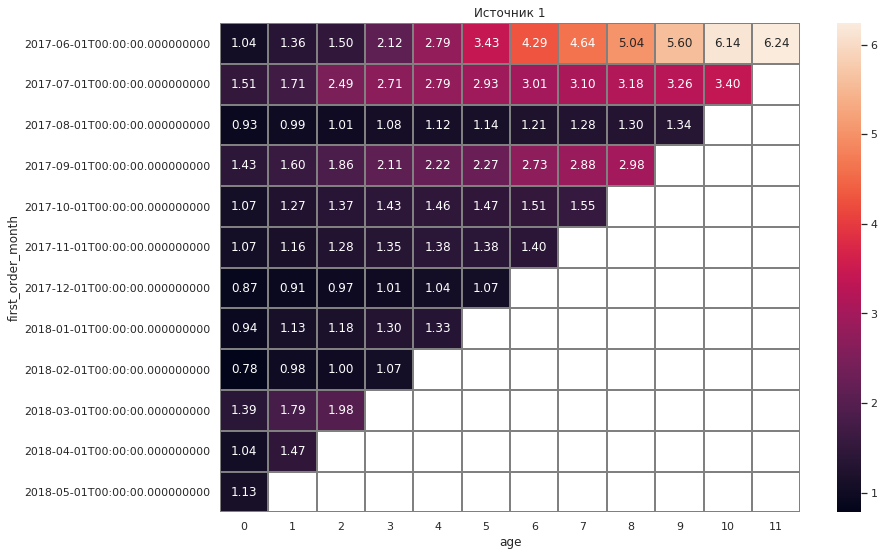

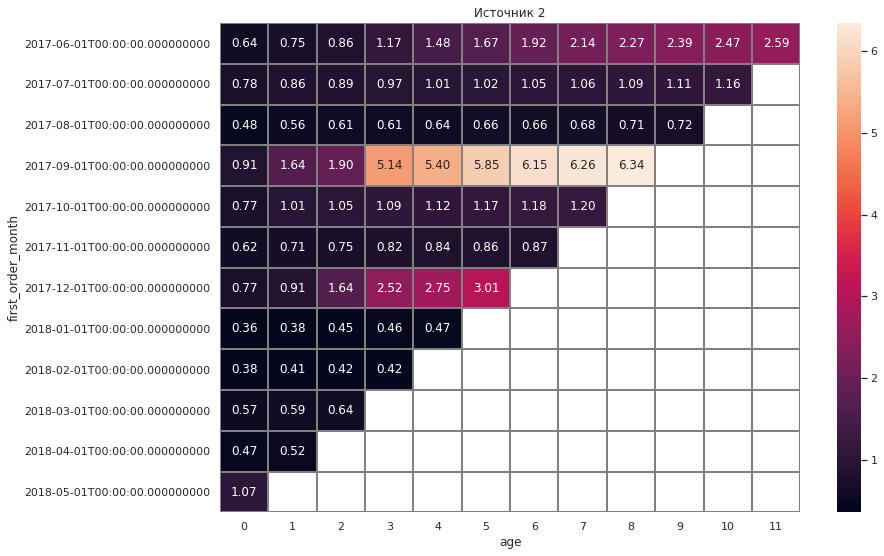

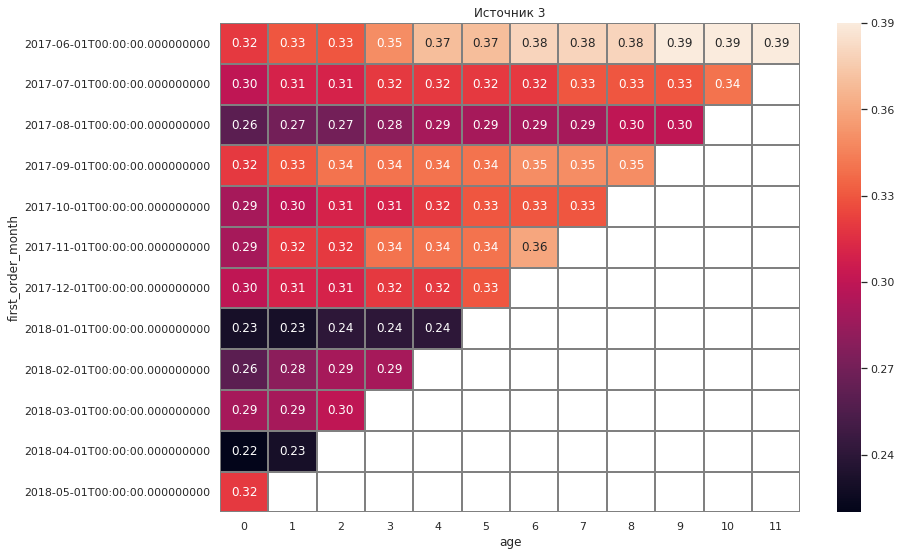

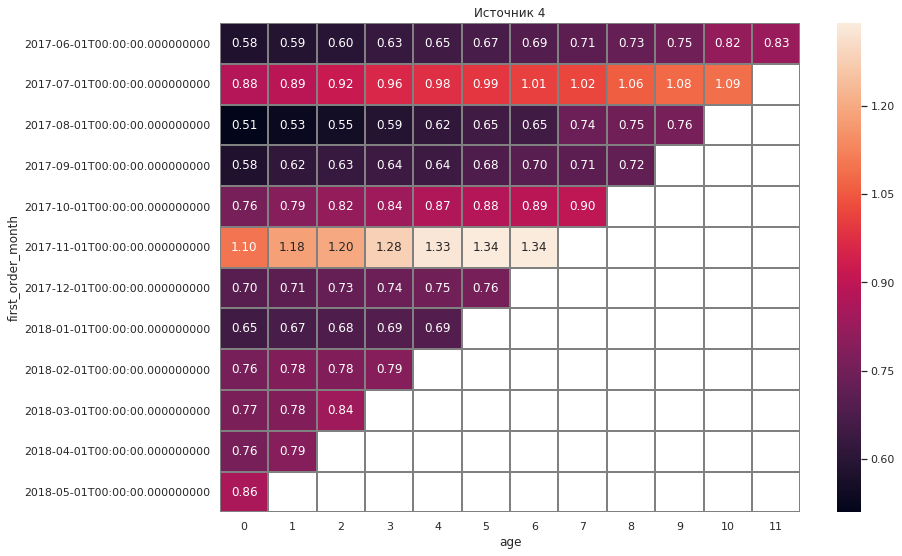

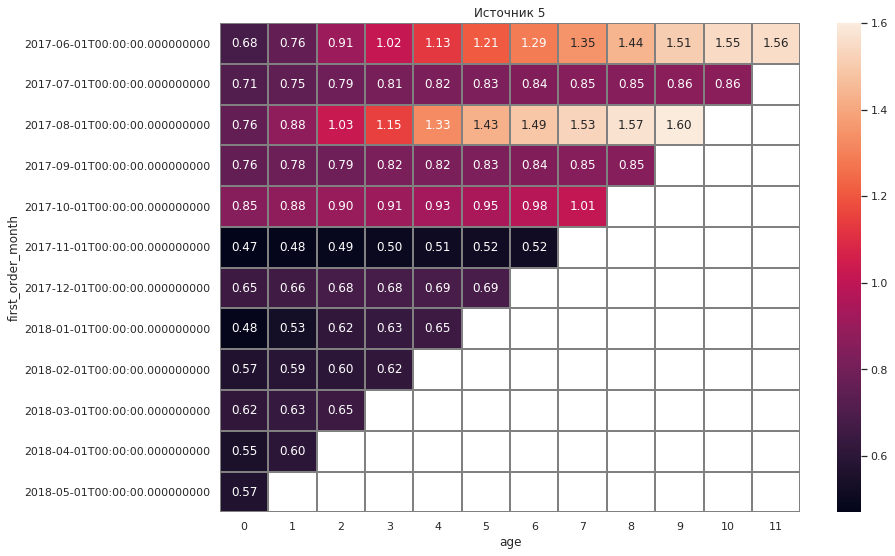

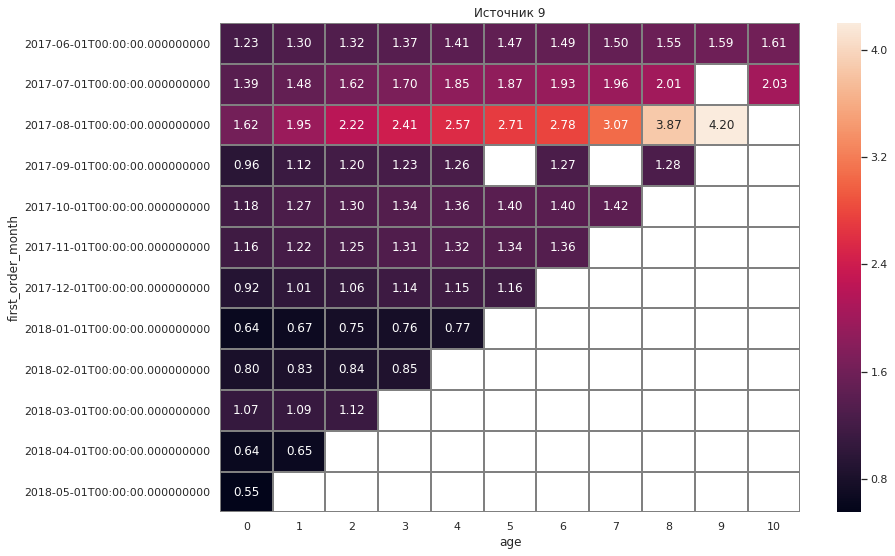

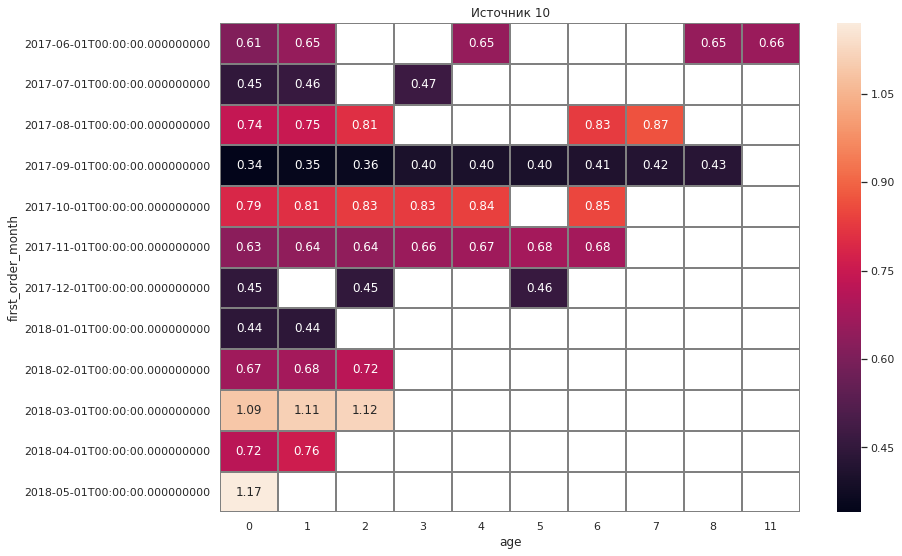

In [72]:
# Посмотрим на окупаемость когорт
for source in report_new.source_id.unique():
    output = report_new.query('source_id == @source').pivot_table(
    index = 'first_order_month',
    columns = 'age',
    values = 'romi',
    aggfunc = 'mean').cumsum(axis=1).round(2)
    display(output)
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title("Источник " + str(source))
    sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

##### По 1-ому источнику все когорты окупаются за 1-3 месяцу. По 2-ому источники некоторые когорты окупаются за 1-2 месяца, но некоторые, например, августовская, и за 10 месяцев не окупилась. По 3-му источнику ни одна когорта не окупилась. По 4-ому источнику когорты окупаются медленно, больше, чем за 10 месяцев. По 5-ому источнику в среднем когорты окупаются за 5-10 месяцев. По 9-ому источнику мнногие когорты окупились в первом же месяцу, но у последних двух когорт этот показатель падает. По 10-ому источнику окупились только 2 когорты, остальные окупаются медленно.

### Посмотрим на изменение различных показателей по устройствам, с которых заходят пользователи

In [73]:
# Посмотрим, с каких девайсов чаще всего приходят пользователи
first_visits_device = df_visits.groupby(['Uid']).agg({'session_month': 'min','Device': 'first' }).reset_index()
device_first = first_visits_device.groupby('Device').agg({'Uid': 'nunique'})
device_first

,Uid
Device,
desktop,160947
touch,67222


Text(0.5, 1.0, 'Посетители, впервые пришедшие на сайт с разных девайсов')

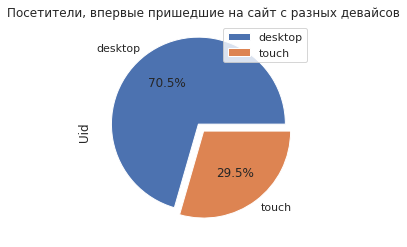

In [74]:
explode = (0.1, 0)
device_first.plot(y='Uid', kind = 'pie', explode = explode, autopct='%1.1f%%')
plt.title('Посетители, впервые пришедшие на сайт с разных девайсов')

In [75]:
# Найдем количество уникальных пользователей по девайсам со временем
visits_device = df_visits.pivot_table(
        index= ['session_month', 'Device'], 
        values='Uid', 
        aggfunc= {'Uid' : lambda x: len(x.unique())}).reset_index()
visits_device.columns = ['month', 'device', 'n_visitors']
display(visits_device.head())

,month,device,n_visitors
0,2017-06-01,desktop,9761
1,2017-06-01,touch,3655
2,2017-07-01,desktop,10145
3,2017-07-01,touch,4223
4,2017-08-01,desktop,8611


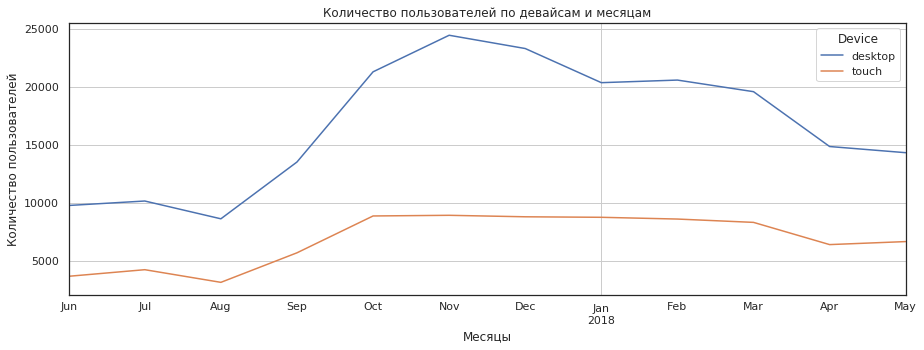

In [76]:
visits_device = df_visits.pivot_table(
        index = 'session_month',
        columns = 'Device', 
        values='Uid', 
        aggfunc= {'Uid' : lambda x: len(x.unique())}).plot(figsize=(15,5), grid = True).set_title('Количество пользователей по девайсам и месяцам')
plt.ylabel("Количество пользователей")
plt.xlabel("Месяцы")
plt.show()

In [77]:
# Рассчитаем Retention rate c разбиением по девайсам
#Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:
cohorts_desktop = vis.query('Device == "desktop"').pivot_table(index = 'first_session_month',
                         columns = 'age_months',
                         values = 'Uid',
                         aggfunc = 'nunique')
cohorts_desktop.fillna('')

age_months,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,9761.0,833,593,671,741,799,656,627,574,552,441,471
2017-07-01,9312.0,568,520,568,602,483,466,463,391,289,265,
2017-08-01,7450.0,603,492,504,406,349,279,302,234,218,,
2017-09-01,11715.0,1034,875,655,485,495,450,302,279,,,
2017-10-01,18451.0,1530,1015,740,681,646,423,413,,,,
2017-11-01,20129.0,1619,902,806,681,489,451,,,,,
2017-12-01,18460.0,972,708,565,371,371,,,,,,
2018-01-01,15809.0,982,638,413,337,,,,,,,
2018-02-01,15586.0,937,418,312,,,,,,,,


In [78]:
# Рассчитаем Retention rate 
retention = pd.DataFrame()
for col in cohorts_desktop.columns:
    retention = pd.concat([retention, cohorts_desktop[col]/cohorts_desktop[0]], axis = 1)
retention.columns = cohorts_desktop.columns
retention.fillna('')

age_months,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01 00:00:00,1.0,0.0853396,0.060752,0.068743,0.0759144,0.0818564,0.0672062,0.0642352,0.0588055,0.0565516,0.0451798,0.0482533
2017-07-01 00:00:00,1.0,0.0609966,0.0558419,0.0609966,0.0646478,0.0518686,0.050043,0.0497208,0.0419888,0.0310352,0.0284579,
2017-08-01 00:00:00,1.0,0.0809396,0.0660403,0.067651,0.0544966,0.0468456,0.0374497,0.0405369,0.0314094,0.0292617,,
2017-09-01 00:00:00,1.0,0.0882629,0.0746906,0.0559112,0.0413999,0.0422535,0.0384123,0.0257789,0.0238156,,,
2017-10-01 00:00:00,1.0,0.0829223,0.0550106,0.0401062,0.0369086,0.0350117,0.0229256,0.0223836,,,,
2017-11-01 00:00:00,1.0,0.0804312,0.044811,0.0400417,0.0338318,0.0242933,0.0224055,,,,,
2017-12-01 00:00:00,1.0,0.0526544,0.0383532,0.0306067,0.0200975,0.0200975,,,,,,
2018-01-01 00:00:00,1.0,0.0621165,0.0403568,0.0261244,0.021317,,,,,,,
2018-02-01 00:00:00,1.0,0.0601181,0.0268189,0.020018,,,,,,,,
2018-03-01 00:00:00,1.0,0.0435054,0.0270608,,,,,,,,,


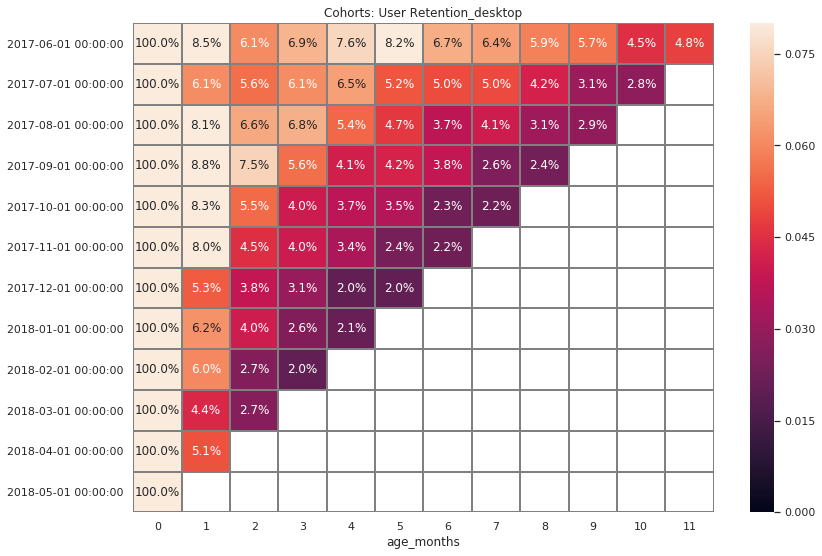

In [79]:
#Построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention_desktop')
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.08);

In [80]:
# Рассчитаем Retention rate для touch
#Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:
cohorts_touch = vis.query('Device == "touch"').pivot_table(index = 'first_session_month',
                         columns = 'age_months',
                         values = 'Uid',
                         aggfunc = 'nunique')
cohorts_touch.fillna('')

age_months,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,3655.0,241,145,173,214,202,201,168,156,157,126,156
2017-07-01,3982.0,191,174,195,191,177,150,151,139,98,109,
2017-08-01,2796.0,199,161,155,114,112,99,111,55,55,,
2017-09-01,5133.0,436,316,227,191,162,166,105,111,,,
2017-10-01,7850.0,576,385,293,241,217,144,126,,,,
2017-11-01,7473.0,581,336,272,265,160,151,,,,,
2017-12-01,7100.0,473,273,237,143,120,,,,,,
2018-01-01,7018.0,410,272,158,130,,,,,,,
2018-02-01,6826.0,358,154,142,,,,,,,,


In [81]:
# Рассчитаем Retention rate
retention = pd.DataFrame()
for col in cohorts_touch.columns:
    retention = pd.concat([retention, cohorts_touch[col]/cohorts_touch[0]], axis = 1)
retention.columns = cohorts_touch.columns
retention.fillna('')

age_months,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01 00:00:00,1.0,0.0659371,0.0396717,0.0473324,0.0585499,0.0552668,0.0549932,0.0459644,0.0426813,0.0429549,0.0344733,0.0426813
2017-07-01 00:00:00,1.0,0.0479658,0.0436966,0.0489704,0.0479658,0.04445,0.0376695,0.0379206,0.0349071,0.0246107,0.0273732,
2017-08-01 00:00:00,1.0,0.0711731,0.0575823,0.0554363,0.0407725,0.0400572,0.0354077,0.0396996,0.019671,0.019671,,
2017-09-01 00:00:00,1.0,0.0849406,0.0615624,0.0442237,0.0372102,0.0315605,0.0323398,0.0204559,0.0216248,,,
2017-10-01 00:00:00,1.0,0.0733758,0.0490446,0.0373248,0.0307006,0.0276433,0.0183439,0.016051,,,,
2017-11-01 00:00:00,1.0,0.0777466,0.0449619,0.0363977,0.035461,0.0214104,0.0202061,,,,,
2017-12-01 00:00:00,1.0,0.0666197,0.0384507,0.0333803,0.0201408,0.0169014,,,,,,
2018-01-01 00:00:00,1.0,0.0584212,0.0387575,0.0225135,0.0185238,,,,,,,
2018-02-01 00:00:00,1.0,0.0524465,0.0225608,0.0208028,,,,,,,,
2018-03-01 00:00:00,1.0,0.039649,0.0272685,,,,,,,,,


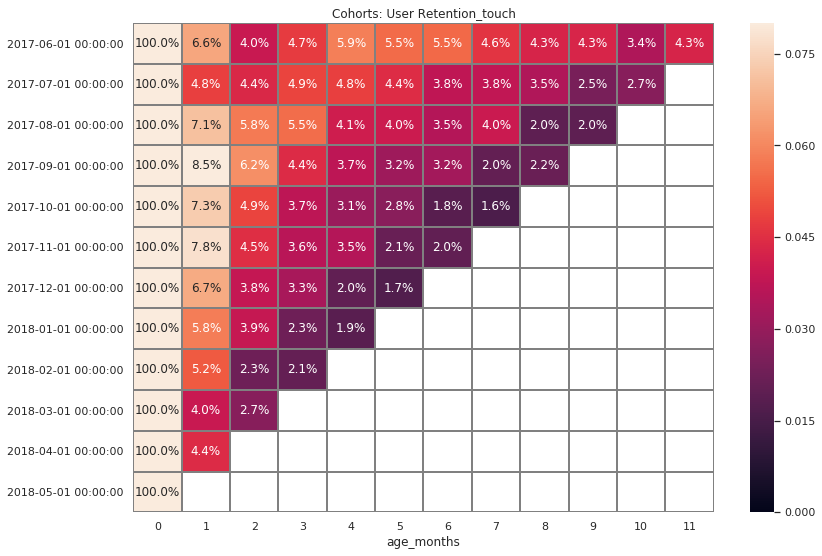

In [82]:
#Построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention_touch')
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.08);

##### 70.5% пользователей пришли с desktop девайсов, остальные c touch.  
##### Количество пользователей, заходящих на сайт с desktop девайсов в среднем в 2.5 раза больше, чем с touch девайсов. Начиная с ноября все меньше пользователей заходит нра сайт с компьютеров. 
##### Retention rate по всем девайсам у последних трех когорт падает. В среднем  retention rate у desktop немного выше.

# Вывод

- Были проанализированы 3 таблицы: посещения, заказы и затраты. В среднем сайт посещают 907 человек в день, 5724 в неделю и 23228 в месяц. В среднем на одного пользователя приходится примерно 1.3 сессии в месяц. Большинство пользователей посещают сайт не чаще одного раза в месяц.В среднем пользователи проводят на сайте чуть больше 10 минут, при этом медианное значение - 5 минут. 
- У распредеоения времени на сайте имеется огромный хвост, но 75% пользователей проводят на сайте до 14 минут. 25% пользователей проводят на сайте до 2 минут. Это может быть связано со случайным кликом на ссылку в поисковике, либо пользователи не разобрались в интерфейсе при заходе на сайт и сразу вышли.
- Меддианное время до первой покупки равно 16.0 минутам. 75% пользователей совершают покупку в течение 4 часов. У распределения имеется большой хвост. В среднем за месяц люди покупают 3155 раз. Повторные покупки со временем совершаются реже на 2-9%. Средний чек равен 5.0. В течение года он менялся от 3.3 до 5.8. Последни 2 месяца наблюдается падение среднего чека. Все когорты окупают себя в первый же месяц, и со временем LTV растет.
- Всего на рекламу было потрачено: 329131.6. Больше всег затрат было на источник № 3, далее идут источники 4 и 5. Меньше всего затрат было на источники № 9 и 10. После августа резко увеличились затраты на рекламу, пик был достигнут в декабре. Далее затраты падали. Видно, что основной рост затрат произошел именно засчет источника №3, который по форме повторяет форму графика общих затрат.
- В среднем стоимость привлечения одного покупателя равна 7.9. Cамые дешевые источники по привлечению клиентов № 9, 10 и 1. А самые высоки САС у источников № 3, 2 и 5. В течение года стоимость привлечения клиента менялась от 2.5 до 21.5 из разных источнков. Видно, что в разные месяцы САС разных источников менялся независимо от других.
- По 1-ому источнику все когорты окупаются за 1-3 месяцу. По 2-ому источники некоторые когорты окупаются за 1-2 месяца, но некоторые, например, августовская, и за 10 месяцев не окупилась. По 3-му источнику ни одна когорта не окупилась. По 4-ому источнику когорты окупаются медленно, больше, чем за 10 месяцев. По 5-ому источнику в среднем когорты окупаются за 5-10 месяцев. По 9-ому источнику мнногие когорты окупились в первом же месяцу, но у последних двух когорт этот показатель падает. По 10-ому источнику окупились только 2 когорты, остальные окупаются медленно.
- 70.5% пользователей пришли с desktop девайсов, остальные c touch. Количество пользователей, заходящих на сайт с desktop девайсов в среднем в 2.5 раза больше, чем с touch девайсов. Начиная с ноября все меньше пользователей заходит на сайт с компьютеров. Retention rate по всем девайсам у последних трех когорт падает. В среднем retention rate у desktop немного выше.

- Не следует повышать затраты на 3-ий источник, так как когорты по нему не окупаются, при этом на данный момент он является самым дорогим. Инвестировать в 1-ый источник можно, он дорогой, но и когорты окупаются быстро. Стоит обратить внимание на 9-ый источник. В нем когорты окупаются довольно быстро, при этом вложений в него мало.
- C desktop девайсов приходит больше пользователей. Этот вид девайсов является более окупаемым.